In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

ip_map = {
    "45.77.229.242": "GB-London",
    "62.154.179.86": "DE-Berlin",
    "194.156.155.241": "ES-Madrid",
    "194.230.35.117": "CH-Zurich",
    "193.46.104.17": "AT-Vienna", #should be .17 but error
    # "193.46.104.12": "AT-Vienna",
    "185.32.189.249": "PT-Lisbon",
    "213.135.49.134": "PL-Warsaw",
    "51.159.68.135": "FR-Paris",
    "185.78.84.3": "TR-Istanbul",
    "185.157.208.248": "GR-Athens"
}

In [2]:
import geopandas as gpd

cities = {
    "GB-London": (-0.0695, 51.5185),
    "DE-Berlin": (13.4205, 52.5495),
    "ES-Madrid": (-3.6215, 40.4405),
    "CH-Zurich": (8.5605, 47.4185),
    "AT-Vienna": (16.4075, 48.2715),
    "PT-Lisbon": (-9.1215, 38.7915),
    "PL-Warsaw": (20.9375, 52.2515),
    "FR-Paris": (2.4075, 48.7905),
    "TR-Istanbul": (28.8305, 40.9915),
    "GR-Athens": (23.7705, 38.0695)
}

df = pd.DataFrame([
    {"city": name, "lon": coord[0], "lat": coord[1]}
    for name, coord in cities.items()
])

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['lon'], df['lat']),
    crs="EPSG:4326"
)

gdf = gdf.to_crs("EPSG:3857")

dist_rows = []
for src_city, dst_city in product(gdf['city'], repeat=2):
    src_geom = gdf[gdf['city'] == src_city].geometry.values[0]
    dst_geom = gdf[gdf['city'] == dst_city].geometry.values[0]
    
    dist_km = src_geom.distance(dst_geom) / 1000
    
    dist_rows.append({
        "src": src_city,
        "dst": dst_city,
        "distance_km": dist_km
    })
dist_df = pd.DataFrame(dist_rows)

In [3]:
http_df = pd.read_csv("data/full/http.csv")

http_df['src'] = http_df['src_addr'].map(ip_map)
http_df['dst'] = http_df['dst_addr'].map(ip_map)

http_df['timestamp'] = pd.to_datetime(http_df['timestamp'], unit='s')
http_df = http_df.sort_values('timestamp')

http_df['pair'] = http_df['src'] + " - " + http_df['dst']

print(http_df)

              ttr method         dst_addr         src_addr         rt  res  \
14111  148.648420    GET  194.156.155.241   185.32.189.249  21.697573  200   
54431   20.011650    GET    45.77.229.242   185.32.189.249  59.944560  200   
78624   29.864662    GET    51.159.68.135  185.157.208.248  94.712110  200   
78623    8.715183    GET    51.159.68.135      185.78.84.3  85.539550  200   
38303    0.930617    GET   213.135.49.134    51.159.68.135  57.069090  200   
...           ...    ...              ...              ...        ...  ...   
78619    0.875461    GET   185.32.189.249    51.159.68.135  71.850400  200   
36284    2.071455    GET   194.230.35.117   213.135.49.134  56.126476  200   
36285   10.396140    GET   194.230.35.117      185.78.84.3  96.023830  200   
36283    1.067529    GET   194.230.35.117    51.159.68.135  39.625890  200   
36286   11.080094    GET   194.230.35.117  185.157.208.248  83.542290  200   

       ver  hsize  bsize     msm_id           timestamp  prb_id

In [11]:
http_errors_df = http_df[http_df['res'] != 200]
http_good_df   = http_df[http_df['rt'] >= 0.0]

print(http_errors_df)

http_good_swapped = http_good_df.rename(columns={'src_addr':'dst_addr', 'dst_addr':'src_addr', 'src':'dst', 'dst':'src'})
http_good_symmetric = pd.concat([http_good_df, http_good_swapped], ignore_index=True)

http_errors_swapped = http_errors_df.rename(columns={'src_addr':'dst_addr', 'dst_addr':'src_addr', 'src':'dst', 'dst':'src'})
http_errors_symmetric = pd.concat([http_errors_df, http_errors_swapped], ignore_index=True)

agg_http_good = http_good_symmetric.groupby(['src', 'dst'])['rt'].mean().reset_index()
agg_http_errors = http_errors_symmetric.groupby(['src', 'dst'])['res'].count().reset_index()

all_names = sorted([x for x in ip_map.values()])
full_pairs = pd.DataFrame(list(product(all_names, all_names)), columns=['src', 'dst'])
full_pairs = full_pairs.merge(dist_df, on=['src', 'dst'], how='left')

merged_good = full_pairs.merge(agg_http_good, on=['src','dst'], how='left')
merged_good['ping_per_km'] = merged_good['rt'] / merged_good['distance_km'] * 1000
merged_good = merged_good.fillna(0).pivot(index='src', columns='dst', values='ping_per_km')

ping_good_heatmap_data = pd.merge(full_pairs, agg_http_good, on=['src', 'dst'], how='left').fillna(0).pivot(index='src', columns='dst', values='rt')
ping_errors_heatmap_data = pd.merge(full_pairs, agg_http_errors, on=['src', 'dst'], how='left').fillna(0).pivot(index='src', columns='dst', values='res')

             ttr method       dst_addr         src_addr   rt  res      ver  \
1427   34.231876    GET  62.154.179.86          timeout  0.0  408  timeout   
1462   33.430990    GET  62.154.179.86  185.157.208.248  0.0  408  timeout   
1588   11.078152    GET  62.154.179.86  185.157.208.248  0.0  408  timeout   
1623   29.716810    GET  62.154.179.86          timeout  0.0  408  timeout   
3299    0.426399    GET  62.154.179.86          timeout  0.0  408  timeout   
...          ...    ...            ...              ...  ...  ...      ...   
13789  29.418278    GET  62.154.179.86          timeout  0.0  408  timeout   
13880  11.116918    GET  62.154.179.86  185.157.208.248  0.0  408  timeout   
13887  36.533928    GET  62.154.179.86  185.157.208.248  0.0  408  timeout   
13908  49.572750    GET  62.154.179.86          timeout  0.0  408  timeout   
13977  11.081078    GET  62.154.179.86          timeout  0.0  408  timeout   

       hsize  bsize     msm_id           timestamp  prb_id     

Text(70.72222222222221, 0.5, 'Source Address')

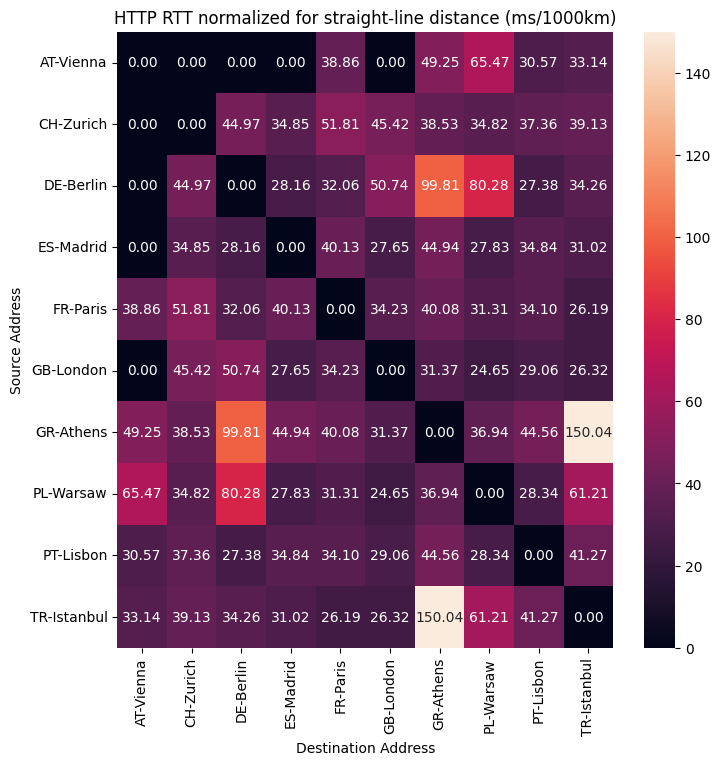

In [9]:
plt.figure(figsize=(8,8))
sns.heatmap(merged_good, annot=True, fmt="0.2f", cmap="rocket")
plt.title("HTTP RTT normalized for straight-line distance (ms/1000km)")
plt.xlabel("Destination Address")
plt.ylabel("Source Address")

Text(70.72222222222221, 0.5, 'Source Address')

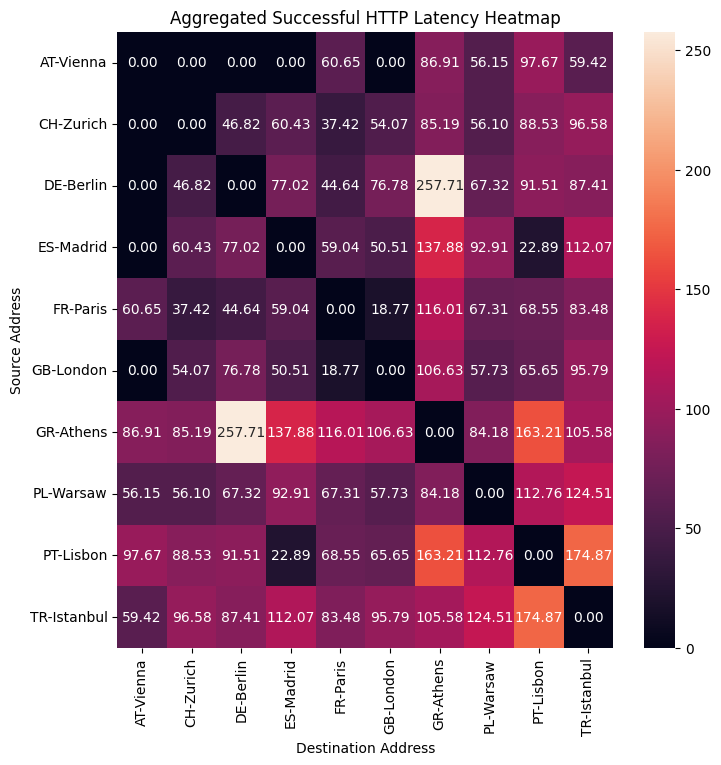

In [6]:
plt.figure(figsize=(8,8))
sns.heatmap(ping_good_heatmap_data, annot=True, fmt="0.2f", cmap="rocket")
plt.title("Aggregated Successful HTTP Latency Heatmap")
plt.xlabel("Destination Address")
plt.ylabel("Source Address")

Text(70.72222222222221, 0.5, 'Source Address')

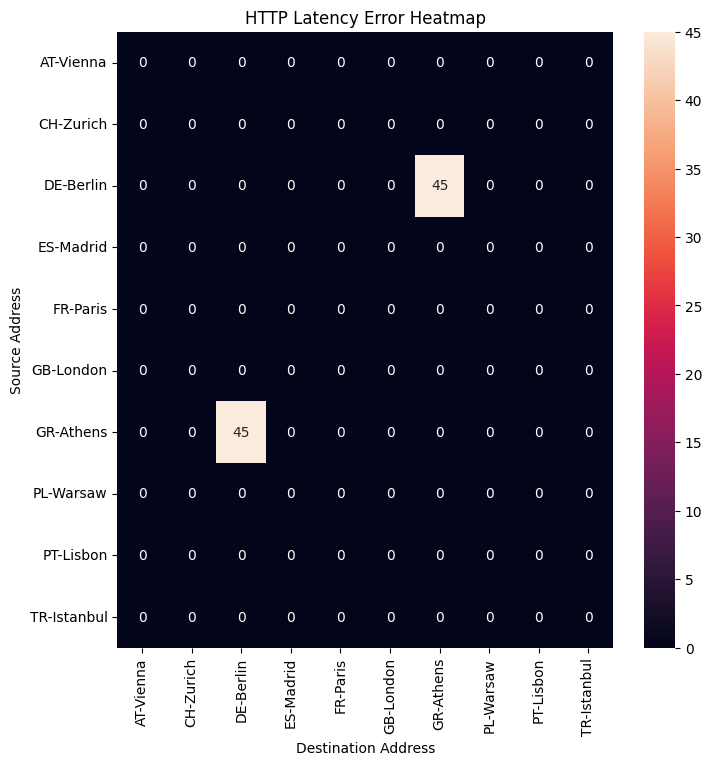

In [7]:
plt.figure(figsize=(8,8))
sns.heatmap(ping_errors_heatmap_data, fmt="0.0f", annot=True, cmap="rocket")
plt.title("HTTP Latency Error Heatmap")
plt.xlabel("Destination Address")
plt.ylabel("Source Address")